# Softmax Regression


In the last two chapters, we worked through implementations
linear regression, building everything from scratch and again using Gluon to automate the most repetitive work.

Regression is the hammer we reach for
when we want to answer *how much?* or *how many?* questions.
If you want to predict the number of dollars (the *price*)
at which a house will be sold,
or the number of wins a baseball team might have,
or the number of days that a patient
will remain hospitalized before being discharged,
then you're probably looking for a regression model.

In practice, we're more often interested in classification:
asking not *how much* but *which one*.

* Does this email belong in the spam folder or the inbox?
* Is this customer more likely *to sign up* or *not to sign up* for a subscription service?
* Does this image depict a donkey, a dog, a cat, or a rooster?
* Which movie is user most likely to watch next?

Colloquially, we use the word *classification* to describe two subtly different problems: (i) those where we are interested only in *hard* assignments of examples to categories, and (ii) those where we wish to make *soft assignments*, i.e., to assess the *probability* that each category applies. One reason why the distinction between these tasks gets blurred is because most often, even when we only care about hard assignments, we still use models that make soft assignments.


## Classification Problems

To get our feet wet, let's start off with a somewhat contrived image classification problem. Here, each input will be a grayscale 2-by-2 image. We can represent each pixel location as a single scalar, representing each image with four features $x_1, x_2, x_3, x_4$. Further, let's assume that each image belongs to one among the categories "cat", "chicken" and "dog".

First, we have to choose how to represent the labels. We have two obvious choices. Perhaps the most natural impulse would be to choose $y \in \{1, 2, 3\}$, where the integers represent {dog, cat, chicken} respectively. This is a great way of *storing* such information on a computer.
If the categories had some natural ordering among them, say if we were trying to predict {baby, child, adolescent, adult}, then it might even make sense to cast this problem as a regression and keep the labels in this format.

But general classification problems do not come with natural orderings among the classes. To deal with problems like this, statisticians invented an alternative way to represent categorical data: the one hot encoding. Here we have a vector with one component for every possible category. For a given instance, we set the component corresponding to *its category* to 1, and set all other components to 0.

$$y \in \{(1, 0, 0), (0, 1, 0), (0, 0, 1)\}$$

In our case, $y$ would be a three-dimensional vector, with $(1,0,0)$ corresponding to "cat", $(0,1,0)$ to "chicken" and $(0,0,1)$ to "dog".

### Network Architecture

In order to estimate multiple classes, we need a model with multiple outputs, one per category. This is one of the main differences between classification and regression models. To address classification with linear models, we will need as many linear functions as we have outputs. Each output will correspond to its own linear function. In our case, since we have 4 features and 3 possible output categories, we will need 12 scalars to represent the weights,  ($w$ with subscripts) and 3 scalars to represent the biases ($b$ with subscripts). We compute these three outputs, $o_1, o_2$, and $o_3$, for each input:

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{21} + x_3 w_{31} + x_4 w_{41} + b_1,\\
o_2 &= x_1 w_{12} + x_2 w_{22} + x_3 w_{32} + x_4 w_{42} + b_2,\\
o_3 &= x_1 w_{13} + x_2 w_{23} + x_3 w_{33} + x_4 w_{43} + b_3.
\end{aligned}
$$

We can depict this calculation with the neural network diagram below. Just as in linear regression, softmax regression is also a single-layer neural network. And since the calculation of each output, $o_1, o_2$, and $o_3$, depends on all inputs, $x_1$, $x_2$, $x_3$, and $x_4$, the output layer of softmax regression can also be described as fully connected layer.



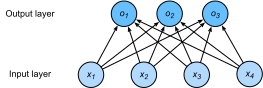

In [1]:
from IPython.display import SVG
SVG(filename='../img/softmaxreg.svg')

Softmax regression is a single-layer neural network.  


### Softmax Operation

To express the model more compactly, we can use linear algebra notation. In vector form, we arrive at $\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$, a form better suited both for mathematics, and for writing code. Note that we have gathered all of our weights into a $3\times4$ matrix and that for a given example $\mathbf{x}$ our outputs are given by a matrix vector product of our weights by our inputs plus our biases $\mathbf{b}$.


If we are interested in hard classifications, we need to convert these outputs into a discrete prediction. One straightforward way to do this is to treat the output values $o_i$ as the relative confidence levels that the item belongs to each category $i$. Then we can choose the class with the largest output value as our prediction $\operatorname*{argmax}_i o_i$. For example, if $o_1$, $o_2$, and $o_3$ are 0.1, 10, and 0.1, respectively, then we predict category 2, which represents "chicken".

However, there are a few problems with using the output from the output layer directly. First, because the range of output values from the output layer is uncertain, it is difficult to judge the meaning of these values. For instance, the output value 10 from the previous example appears to indicate that we are *very confident* that the image category is *chicken*. But just how confident? Is it 100 times more likely to be a chicken than a dog or are we less confident?

Moreover how do we train this model. If the argmax matches the label, then we have no error at all! And if if the argmax is not equal to the label, then no infinitesimal change in our weights will decrease our error. That takes gradient-based learning off the table.

We might like for our outputs to correspond to probabilities, but then we would need a way to guarantee that on new (unseen) data the probabilities would be nonnegative and sum up to 1. Moreover, we would need a training objective that encouraged the model to actually estimate *probabilities*.
Fortunately, statisticians have conveniently invented a model
called softmax logistic regression that does precisely this.

In order to ensure that our outputs are nonnegative and sum to 1,
while requiring that our model remains differentiable,
we subject the outputs of the linear portion of our model
to a nonlinear *softmax* function:

$$
\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o}) \text{ where }
\hat{y}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}
$$

It is easy to see $\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$ with $0 \leq \hat{y}_i \leq 1$ for all $i$. Thus, $\hat{y}$ is a proper probability distribution and the values of $o$ now assume an easily quantifiable meaning. Note that we can still find the most likely class by

$$
\hat{\imath}(\mathbf{o}) = \operatorname*{argmax}_i o_i = \operatorname*{argmax}_i \hat y_i
$$

In short, the softmax operation preserves the orderings of its inputs, and thus does not alter the predicted category vs our simpler *argmax* model. However, it gives the outputs $\mathbf{o}$ proper meaning: they are the pre-softmax values determining the probabilities assigned to each category. Summarizing it all in vector notation we get ${\mathbf{o}}^{(i)} = \mathbf{W} {\mathbf{x}}^{(i)} + {\mathbf{b}}$ where ${\hat{\mathbf{y}}}^{(i)} = \mathrm{softmax}({\mathbf{o}}^{(i)})$.


### Vectorization for Minibatches

Again, to improve computational efficiency and take advantage of GPUs, we will typically carry out vector calculations for mini-batches of data. Assume that we are given a mini-batch $\mathbf{X}$ of examples with dimensionality $d$ and batch size $n$. Moreover, assume that we have $q$ categories (outputs). Then the minibatch features $\mathbf{X}$ are in $\mathbb{R}^{n \times d}$, weights $\mathbf{W} \in \mathbb{R}^{d \times q}$ and the bias satisfies $\mathbf{b} \in \mathbb{R}^q$.

$$
\begin{aligned}
\mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b} \\
\hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O})
\end{aligned}
$$

This accelerates the dominant operation into a matrix-matrix product $\mathbf{W} \mathbf{X}$ vs the matrix-vector products we would be executing if we processed one example at a time. The softmax itself can be computed by exponentiating all entries in $\mathbf{O}$ and then normalizing them by the sum appropriately.

## Loss Function

Now that we have some mechanism for outputting probabilities, we need to transform this into a measure of how accurate things are, i.e. we need a *loss function*. For this, we use the same concept that we already encountered in linear regression, namely likelihood maximization.

### Log-Likelihood

The softmax function maps $\mathbf{o}$ into a vector of probabilities corresponding to various outcomes, such as $p(y=\mathrm{cat}|\mathbf{x})$. This allows us to compare the estimates with reality, simply by checking how well it predicted what we observe.

$$
p(Y|X) = \prod_{i=1}^n p(y^{(i)}|x^{(i)})
\text{ and thus }
-\log p(Y|X) = \sum_{i=1}^n -\log p(y^{(i)}|x^{(i)})
$$


Maximizing $p(Y|X)$ (and thus equivalently minimizing $-\log p(Y|X)$)
corresponds to predicting the label well.
This yields the loss function (we dropped the superscript $(i)$ to avoid notation clutter):

$$
l = -\log p(y|x) = - \sum_j y_j \log \hat{y}_j
$$

Here we used that by construction $\hat{y} = \mathrm{softmax}(\mathbf{o})$ and moreover, that the vector $\mathbf{y}$ consists of all zeroes but for the correct label, such as $(1, 0, 0)$. Hence the sum over all coordinates $j$ vanishes for all but one term. Since all $\hat{y}_j$ are probabilities, their logarithm is never larger than $0$. Consequently, the loss function is minimized if we correctly predict $y$ with *certainty*, i.e. if $p(y|x) = 1$ for the correct label.

### Softmax and Derivatives

Since the Softmax and the corresponding loss are so common, it is worth while understanding a bit better how it is computed. Plugging $o$ into the definition of the loss $l$ and using the definition of the softmax we obtain:

$$
l = -\sum_j y_j \log \hat{y}_j = \sum_j y_j \log \sum_k \exp(o_k) - \sum_j y_j o_j
= \log \sum_k \exp(o_k) - \sum_j y_j o_j
$$

To understand a bit better what is going on, consider the derivative with respect to $o$. We get

$$
\partial_{o_j} l = \frac{\exp(o_j)}{\sum_k \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j = \Pr(y = j|x) - y_j
$$

In other words, the gradient is the difference between the probability assigned to the true class by our model, as expressed by the probability $p(y|x)$, and what actually happened, as expressed by $y$. In this sense, it is very similar to what we saw in regression, where the gradient was the difference between the observation $y$ and estimate $\hat{y}$. This is not coincidence. In any [exponential family](https://en.wikipedia.org/wiki/Exponential_family) model, the gradients of the log-likelihood are given by precisely this term. This fact makes computing gradients easy in practice.

### Cross-Entropy Loss

Now consider the case where we don't just observe a single outcome but maybe, an entire distribution over outcomes. We can use the same representation as before for $y$. The only difference is that rather than a vector containing only binary entries, say $(0, 0, 1)$, we now have a generic probability vector, say $(0.1, 0.2, 0.7)$. The math that we used previously to define the loss $l$ still works out fine, just that the interpretation is slightly more general. It is the expected value of the loss for a distribution over labels.

$$
l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_j y_j \log \hat{y}_j
$$

This loss is called the cross-entropy loss and it is one of the most commonly used losses for multiclass classification. To demystify its name we need some information theory. The following section can be skipped if needed.

## Information Theory Basics

Information theory deals with the problem of encoding, decoding, transmitting and manipulating information (aka data), preferentially in as concise form as possible.

### Entropy

A key concept is how many bits of information (or randomness) are contained in data. It can be measured as the [entropy](https://en.wikipedia.org/wiki/Entropy) of a distribution $p$ via

$$
H[p] = \sum_j - p(j) \log p(j)
$$

One of the fundamental theorems of information theory states that in order to encode data drawn randomly from the distribution $p$ we need at least $H[p]$ 'nats' to encode it. If you wonder what a 'nat' is, it is the equivalent of bit but when using a code with base $e$ rather than one with base 2. One nat is $\frac{1}{\log(2)} \approx 1.44$ bit. $H[p] / \log 2$ is often also called the binary entropy.

To make this all a bit more theoretical consider the following: $p(1) = \frac{1}{2}$ whereas $p(2) = p(3) = \frac{1}{4}$. In this case we can easily design an optimal code for data drawn from this distribution, by using `0` to encode 1, `10` for 2 and `11` for 3. The expected number of bit is $1.5 = 0.5 * 1 + 0.25 * 2 + 0.25 * 2$. It is easy to check that this is the same as the binary entropy $H[p] / \log 2$.

### Kullback Leibler Divergence

One way of measuring the difference between two distributions arises directly from the entropy. Since $H[p]$ is the minimum number of bits that we need to encode data drawn from $p$, we could ask how well it is encoded if we pick the 'wrong' distribution $q$. The amount of extra bits that we need to encode $q$ gives us some idea of how different these two distributions are. Let us compute this directly - recall that to encode $j$ using an optimal code for $q$ would cost $-\log q(j)$ nats, and we need to use this in $p(j)$ of all cases. Hence we have

$$
D(p\|q) = -\sum_j p(j) \log q(j) - H[p] = \sum_j p(j) \log \frac{p(j)}{q(j)}
$$

Note that minimizing $D(p\|q)$ with respect to $q$ is equivalent to minimizing the cross-entropy loss. This can be seen directly by dropping $H[p]$ which doesn't depend on $q$. We thus showed that softmax regression tries the minimize the surprise (and thus the number of bits) we experience when seeing the true label $y$ rather than our prediction $\hat{y}$.

## Model Prediction and Evaluation

After training the softmax regression model, given any example features, we can predict the probability of each output category. Normally, we use the category with the highest predicted probability as the output category. The prediction is correct if it is consistent with the actual category (label). In the next part of the experiment, we will use accuracy to evaluate the model’s performance. This is equal to the ratio between the number of correct predictions and the total number of predictions.

## Summary

* We introduced the softmax operation which takes a vector maps it into probabilities.
* Softmax regression applies to classification problems. It uses the probability distribution of the output category in the softmax operation.
* Cross entropy is a good measure of the difference between two probability distributions. It measures the number of bits needed to encode the data given our model.

## Exercises

1. Show that the Kullback-Leibler divergence $D(p\|q)$ is nonnegative for all distributions $p$ and $q$. Hint - use Jensen's inequality, i.e. use the fact that $-\log x$ is a convex function.
1. Show that $\log \sum_j \exp(o_j)$ is a convex function in $o$.
1. We can explore the connection between exponential families and the softmax in some more depth
    * Compute the second derivative of the cross entropy loss $l(y,\hat{y})$ for the softmax.
    * Compute the variance of the distribution given by $\mathrm{softmax}(o)$ and show that it matches the second derivative computed above.
1. Assume that we three classes which occur with equal probability, i.e. the probability vector is $(\frac{1}{3}, \frac{1}{3}, \frac{1}{3})$.
    * What is the problem if we try to design a binary code for it? Can we match the entropy lower bound on the number of bits?
    * Can you design a better code. Hint - what happens if we try to encode two independent observations? What if we encode $n$ observations jointly?
1. Softmax is a misnomer for the mapping introduced above (but everyone in deep learning uses it). The real softmax is defined as $\mathrm{RealSoftMax}(a,b) = \log (\exp(a) + \exp(b))$.
    * Prove that $\mathrm{RealSoftMax}(a,b) > \mathrm{max}(a,b)$.
    * Prove that this holds for $\lambda^{-1} \mathrm{RealSoftMax}(\lambda a, \lambda b)$, provided that $\lambda > 0$.
    * Show that for $\lambda \to \infty$ we have $\lambda^{-1} \mathrm{RealSoftMax}(\lambda a, \lambda b) \to \mathrm{max}(a,b)$.
    * What does the soft-min look like?
    * Extend this to more than two numbers.